In [66]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

## Training a BPE tokenizer in spanish

In [67]:
import re
class BPE_regex:
    def __init__(self):
        self.merges_map = dict()
        self.vocabulary = {idx: bytes([idx]) for idx in range(256)}
        self.pat = r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+| \d+| ?[^\s\w\d]+|\s+(?!\S)|\s+" # contractions, words, numbers, punctuation, continued spaces except 
        # the last space so it doesn't destroy the structure where a word or number starts with a space, and finally continued spaces at the end of the string 

    def decode(self, encoded):
        # Join the bytes as a string of bytes and then decode
        return b''.join([self.vocabulary[idx] for idx in encoded]).decode('utf-8', errors='replace')
    
    def encode(self, text):
        tokens = []
        for token in re.findall(self.pat, text, re.IGNORECASE):
            tokens.extend(tokenizer._encode(token))
        return tokens
    
    def _encode(self, text):
        # Transform string to a list of bytes
        encoded = list(text.encode('utf-8'))

        while len(encoded) > 1:
            # Find the pair that should be merged first: It is the pair that has the lowest id in the vocabulary
            pairs = set()
            for pair in zip(encoded[:-1], encoded[1:]):
                pairs.add(pair)
            pair_to_merge = min(pairs, key=lambda pair: self.merges_map.get(pair, float('inf'))) # The pair with the lowest index

            # If there is no pair to merge break out of the loop
            if pair_to_merge not in self.merges_map:
                break

            # Replace each merged token one by one in the merged order
            new_tokens = []
            i = 0
            while i < len(encoded):
                pair = encoded[i], encoded[i+1] if i < len(encoded) -1 else None # if is the last position pair is None
                # If there is pair to merge add the proper id and advance i to skip the tail of the pair
                if pair is not None and pair == pair_to_merge:
                    new_tokens.append(self.merges_map[pair_to_merge])
                    i += 1
                # If there is no pair to merge, add the id i in the ith position
                else:
                    new_tokens.append(encoded[i])
                # Go to the next id
                i += 1
            encoded = new_tokens

        return encoded

    def train(self, corpus, vocab_size: int):
        self.vocab_size = vocab_size
        pre_tokens = re.findall(self.pat, corpus, re.IGNORECASE)
        new_encoded = [list(tok.encode('utf-8')) for tok in pre_tokens]

        vocab_size = 256 # initial vocab_size is the number of bytes
        while vocab_size < self.vocab_size:
            # Count pairs
            counts = {}
            for fragment in new_encoded:
                for pair in zip(fragment[:-1], fragment[1:]):
                    counts[pair] = counts.get(pair, 0) + 1
            # Get the pair to create the new token
            max_pair = max(counts, key=counts.get)

            # Save the new token
            new_tok_id = vocab_size
            self.vocabulary[new_tok_id] = self.vocabulary[max_pair[0]] + self.vocabulary[max_pair[1]] # Concatenate the bytes
            self.merges_map[max_pair] = new_tok_id
            vocab_size += 1

            # Check if there is any merging to do
            new_tokens = []
            for fragment in new_encoded:
                fragment_tokens = []
                i = 0
                while i < len(fragment):
                    pair = fragment[i], fragment[i+1] if i < len(fragment) -1 else None # if is the last position pair is None
                    if pair is not None and pair == max_pair:
                        fragment_tokens.append(new_tok_id)
                        i += 1
                    else:
                        fragment_tokens.append(fragment[i])
                    i += 1
                new_tokens.append(fragment_tokens)
            new_encoded = new_tokens

    def save(self, file_name: str):
        os.makedirs('tokenizer', exist_ok=True)
        file_path = os.path.join('tokenizer', file_name + '.pkl')
        with open(file_path, 'wb') as file:
            pickle.dump(self, file)

    @staticmethod
    def load(file_name: str):
        file_path = os.path.join('tokenizer', file_name + '.pkl')
        with open(file_path, 'rb') as file:
            return pickle.load(file)

In [68]:
# Train the tokenizer
# with open('isla_del_tesoro.txt') as file:
#     corpus = file.read()
# tokenizer = BPE_regex()
# tokenizer.train(corpus, 2000)

In [69]:
# Save the tokenizer
# tokenizer.save('bpe_spanish_2000')

In [70]:
# load a previously trained tokenizer
tokenizer = BPE_regex.load('bpe_spanish_2000')

In [71]:
# Show the tokens in the vocabulary
for id, token in tokenizer.vocabulary.items():
    print(f"""token {id}: \"{token.decode('utf-8', errors='replace')}\"""")

token 0: " "
token 1: ""
token 2: ""
token 3: ""
token 4: ""
token 5: ""
token 6: ""
token 7: ""
token 8: "
token 9: "	"
token 10: "
"
token 11: ""
token 12: ""
"oken 13: "
token 14: ""
token 15: ""
token 16: ""
token 17: ""
token 18: ""
token 19: ""
token 20: ""
token 21: ""
token 22: ""
token 23: ""
token 24: ""
token 25: ""
token 26: ""
token 27: ""
token 28: ""
token 29: ""
token 30: ""
token 31: ""
token 32: " "
token 33: "!"
token 34: """
token 35: "#"
token 36: "$"
token 37: "%"
token 38: "&"
token 39: "'"
token 40: "("
token 41: ")"
token 42: "*"
token 43: "+"
token 44: ","
token 45: "-"
token 46: "."
token 47: "/"
token 48: "0"
token 49: "1"
token 50: "2"
token 51: "3"
token 52: "4"
token 53: "5"
token 54: "6"
token 55: "7"
token 56: "8"
token 57: "9"
token 58: ":"
token 59: ";"
token 60: "<"
token 61: "="
token 62: ">"
token 63: "?"
token 64: "@"
token 65: "A"
token 66: "B"
token 67: "C"
token 68: "D"
token 69: "E"
token 70: "F"
token 71: "G"
token 

## Prepare the dataset

A dataset of wikipedia articles in spanish

In [72]:
# Load a 1.7M wikipedia articles in spanish
dataset = load_from_disk('wikipedia')

In [73]:
# Calculate the characters length of each article
dataset = dataset.map(lambda x: {'text_length': len(x['text'])}, num_proc=5)

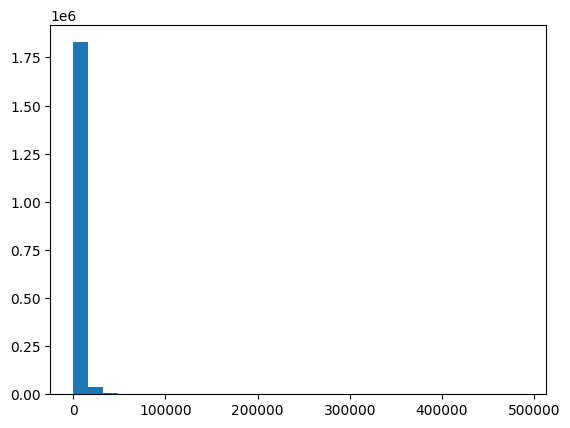

In [74]:
# Make a histogram of the text lengths
plt.hist(dataset['text_length'], bins=30)
plt.show()

In [75]:
# Make table of percentiles
percentiles = np.percentile(dataset['text_length'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
percentiles

array([8.00000e+00, 3.09000e+02, 4.85000e+02, 7.44000e+02, 1.03100e+03,
       1.39300e+03, 1.92200e+03, 2.69400e+03, 3.98100e+03, 6.92300e+03,
       4.88777e+05])

In [76]:
# Remove very short articles
dataset = dataset.filter(lambda x: len(x['text']) > 309)
dataset

Dataset({
    features: ['id', 'url', 'title', 'text', 'text_length'],
    num_rows: 1691121
})

In [77]:
# Encode each of the articles
# dataset = dataset.map(lambda x: {'encoded' :tokenizer.encode(x['text'])},batch_size=4000, num_proc=30)

In [78]:
# Save the encoded dataset
# dataset.save_to_disk('wikipedia_encoded', num_proc=20)

In [79]:
# load the encoded dataset
dataset = load_from_disk('wikipedia_encoded')

In [80]:
# Remove short articles (less than 300 tokens)
dataset = dataset.filter(lambda x: len(x['encoded']) > 300, num_proc=20)

In [81]:
# Total number of tokens in the dataset
# total_tokens = 0
# for batch in dataset.iter(batch_size=100000):
#     total_tokens += len(np.hstack(batch['encoded']))
# total_tokens

In [82]:
# Reserve some articles for validation
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text', 'text_length', 'encoded'],
        num_rows: 1106343
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'text', 'text_length', 'encoded'],
        num_rows: 276586
    })
})

## Training the GPT model

In [97]:
# Hyper-parameters
import torch
import torch.nn as nn
import torch.nn.functional as F

block_size = 256
emb_dim = 512
batch_size = 64
head_dim = 512
blocks_num = 6
heads_num = 8
droput = 0.4

# Training
steps = 10000
learning_rate = 3e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [98]:
import random
# Create a batch from the dataset
def get_batch(split='train'):
    data = dataset[split]
    # Choose at random a batch of articles
    docs = np.random.randint(len(data), size=batch_size)
    # Choose at random a sequence from the articles
    ix = [random.randint(0, len(data[int(d)]['encoded']) - block_size-1) for d in docs]
    # For every letter, the target is the letter to the right
    x = torch.stack([torch.tensor(data[int(d)]['encoded'][i:i+block_size]) for d, i in zip(docs, ix)])
    y = torch.stack([torch.tensor(data[int(d)]['encoded'][i+1:i+block_size+1]) for d, i in zip(docs, ix)])
    return x.to(device), y.to(device)

x, y = get_batch('train')
x.shape, y.shape 

(torch.Size([64, 256]), torch.Size([64, 256]))

In [99]:
# Show some examples of the training data
for i in range(8):
    print(f'\n\nEXAMPLE {i+1}:')
    for j in range(x.shape[1]):
        print(f'{tokenizer.decode(x[i,:j+1].cpu().numpy())} -> {tokenizer.decode([y[i,j].item()])}')



EXAMPLE 1:
 A -> si
 Asi -> mis
 Asimis -> mo
 Asimismo -> ,
 Asimismo, ->  se
 Asimismo, se ->  de
 Asimismo, se de -> f
 Asimismo, se def -> in
 Asimismo, se defin -> e
 Asimismo, se define ->  un
 Asimismo, se define un ->  tra
 Asimismo, se define un tra -> bajo
 Asimismo, se define un trabajo ->  espe
 Asimismo, se define un trabajo espe -> ci
 Asimismo, se define un trabajo especi -> al
 Asimismo, se define un trabajo especial ->  y
 Asimismo, se define un trabajo especial y ->  di
 Asimismo, se define un trabajo especial y di -> fer
 Asimismo, se define un trabajo especial y difer -> en
 Asimismo, se define un trabajo especial y diferen -> ci
 Asimismo, se define un trabajo especial y diferenci -> ado
 Asimismo, se define un trabajo especial y diferenciado ->  con
 Asimismo, se define un trabajo especial y diferenciado con ->  el
 Asimismo, se define un trabajo especial y diferenciado con el ->  den
 Asimismo, se define un trabajo especial y diferenciado con el den -> om
 Asim

In [100]:
# GPT model
from torch import nn

class Head(nn.Module):
    def __init__(self,inp_dim, h_dim, block_size):
        super().__init__()
        self.Wq = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wk = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.Wv = nn.Parameter(torch.randn((inp_dim, h_dim), device=device) * inp_dim**-0.5)
        self.tril = torch.tril(torch.ones(block_size, block_size, device=device))

        self.dropout = nn.Dropout(droput)

    def forward(self, x):
        B, T, C = x.shape
        Q = x @ self.Wq
        K = x @ self.Wk
        V = x @ self.Wv
        attention = Q @ K.transpose(-2, -1) # [B,T,C]@[B,C,T] = [B,T,T]
        attention *= Q.shape[-1]**-0.5
        masked_attention = attention.masked_fill(self.tril[:T,:T] == 0, -torch.inf) # Mask future tokens. The [:T,:T] is to be able to work with inputs of less than T tokens, this is helpful for generation
        att_weights = F.softmax(masked_attention, dim=2) # Regularize the weights
        att_weights = self.dropout(att_weights)
        return att_weights @ V # [B,T,T]@[B,T,C] = [B,T,C] Make a weighted average of the vectors the possition attends to

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(input_dim, head_dim//num_heads, block_size) for _ in range(num_heads)])
        self.linear = nn.Linear(head_dim, input_dim)

        self.droput = nn.Dropout(droput)

    def forward(self, x):
        att = torch.cat([h(x) for h in self.heads], dim=-1)
        att = self.linear(att)
        att = self.droput(att)
        return att
    
class Block(nn.Module):
    def __init__(self, num_heads, emb_dim, block_size):
        super().__init__()
        self.selfAttention = MultiHeadAttention(emb_dim, num_heads, block_size)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ffd = nn.Sequential(
            nn.Linear(emb_dim, 4*emb_dim), # scale up
            nn.ReLU(),
            nn.Linear(4*emb_dim, emb_dim), # scale down again for compatibility with the residual connections
            nn.Dropout(droput)
        )
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        att = self.selfAttention(x)
        att = self.ln1(att + x)
        x = self.ffd(x)
        x = self.ln2(att + x)
        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(len(tokenizer.vocabulary), emb_dim)
        self.pos_emb = nn.Embedding(block_size, emb_dim)

        self.blocks = nn.Sequential(*[Block(heads_num, emb_dim, block_size) for _ in range(blocks_num)]) # Without the * it breaks

        self.final_dropout = nn.Dropout(droput)

        self.final_proj = nn.Linear(head_dim, len(tokenizer.vocabulary))

    def forward(self, x, targets=None):
        emb1 = self.token_emb(x)
        # print(emb1.shape)
        emb2 = self.pos_emb(torch.arange(emb1.shape[1], device=device)) # Use emb.shape[1] instead of block_size because of inference. To being able to generate a prediction starting from 1 token with a max of block_size
        # print(emb2.shape)
        emb = emb1 + emb2
        # print(emb.shape)
        x = self.blocks(emb)

        x = self.final_dropout(x)
        # print(att.shape)
        logits = self.final_proj(x)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(batch_size*block_size, -1), targets.view(batch_size*block_size))
        return logits, loss

In [101]:
# Define function to estimate the training and validation losses
@torch.no_grad
def estimate_loss():
    model.eval()
    samples = 30
    # Estimate train loss
    losses = []
    for i in range(samples):
        x, y = get_batch('train')
        _, loss = model(x, y)
        losses.append(loss.item())
    train_loss = sum(losses)/samples
    # Estimate Validation loss
    losses = []
    for i in range(samples):
        x, y = get_batch('test')
        _, loss = model(x, y)
        losses.append(loss.item())
    val_loss = sum(losses)/samples
    model.train()
    return train_loss, val_loss

In [102]:
# Define the training loop
import math

model = GPTModel()
def train_model(model, steps, learning_rate):
    train_lossi = []
    val_lossi = []
    model.train()
    model = model.to(device)
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

    # Baseline loss
    print('baseline loss', -math.log(1/len(tokenizer.vocabulary)))

    for i in range(steps):
        x, y = get_batch('train')
        logits, loss = model(x, y)
        if (i+1) % 500 == 0 or i == 0:
            train_loss, val_loss = estimate_loss()
            print(f'step {i+1}: train loss {train_loss:.2f} - val loss {val_loss:.2f}')

            # Track stats
            train_lossi.append(train_loss)
            val_lossi.append(val_loss)
        
        # Update the weights
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return train_lossi, val_lossi

In [110]:
# Actual training
train_loss, val_loss = train_model(model, steps, learning_rate)

21.08616 M parameters
baseline loss 7.600902459542082
step 1: train loss 2.52 - val loss 2.50
step 500: train loss 2.52 - val loss 2.51
step 1000: train loss 2.48 - val loss 2.53
step 1500: train loss 2.47 - val loss 2.50
step 2000: train loss 2.50 - val loss 2.51
step 2500: train loss 2.47 - val loss 2.46
step 3000: train loss 2.47 - val loss 2.45
step 3500: train loss 2.43 - val loss 2.43
step 4000: train loss 2.45 - val loss 2.47
step 4500: train loss 2.44 - val loss 2.44
step 5000: train loss 2.40 - val loss 2.44
step 5500: train loss 2.45 - val loss 2.44
step 6000: train loss 2.42 - val loss 2.42
step 6500: train loss 2.41 - val loss 2.43
step 7000: train loss 2.41 - val loss 2.39
step 7500: train loss 2.41 - val loss 2.41
step 8000: train loss 2.41 - val loss 2.40
step 8500: train loss 2.40 - val loss 2.42
step 9000: train loss 2.39 - val loss 2.40
step 9500: train loss 2.38 - val loss 2.39
step 10000: train loss 2.36 - val loss 2.40


In [111]:
torch.save(model.state_dict(), 'saved_models/gpt_esp.pkl')

In [109]:
model = GPTModel()
model.load_state_dict(torch.load('saved_models/gpt_esp.pkl'))
model = model.to(device)

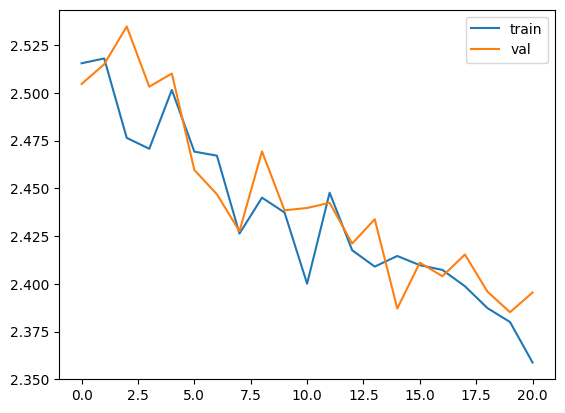

In [112]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()

In [116]:
# Generation example
model.eval()
@torch.no_grad
def generate(max_tokens=500):
    sample = torch.tensor([tokenizer.encode(' El')], device=device)
    while sample.shape[-1] < max_tokens:
        logits, loss = model(sample[:,:block_size])
        logits = logits[:,-1,:]
        # print(logits.shape)
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 20, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        next_tok = torch.gather(topk_indices, -1, ix)
        sample = torch.cat((sample, next_tok), dim=-1)
    return tokenizer.decode(sample[0].cpu().numpy())

print(generate())

 El evento se ubica en la ciudad de Fernando Montaña, donde se encuentran en la capital del Reino de Janeiro, Bélgica, Kamakaneiro. La capital está situada en la capital de las Paradas de Paradas y se encuentra dentro de la localidad de Chilena, con la provincia de Paradas de Paradas y León.

Demografía 
Según el Conteo de Economía de la provincia de Paradas de Chilena (Columbia de Chilena), el 22 de abril de 2017, el municipio está situado en el norte a la provincia de Guatemala, a la provincia de Tasmania, y por la provincia de Tasmania (Columbia de Paradas).

Composiposiposiunposiposiposiposiunposiposiposiunposiunposiposiposiposiposiposiprenposiposiposiposiposiposiposiposiposiunposiposiposiposiposiposiunposiposiunposiposiposiposiposiposiposiposiununposiposiposiposiposiunposiposiposiposiposiununposiunposiposiposiposiposiunposiposiposiposiposiposiposiposiposiposiposiunposiposiposiposiposiposiposiposiposiposiunposiunposiposiposiposiposiposiposiprenposiunposiunposiposiposiposiposiposipo